In [29]:
import librosa
import numpy as np
import random
import rosbag
import struct
import tams_pr2_guzheng
from collections import Counter

from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.style.use('seaborn-v0_8')
from matplotlib.animation import FuncAnimation
from IPython import display


In [5]:
# enable publisher for audio
import rospy
rospy.init_node('jupyter_lab')

In [6]:
%load_ext autoreload
%autoreload 1
import sys
if '../utils' not in sys.path:
    sys.path.append('../utils')
import u
%aimport u

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
bag_name = 'guzheng_reworked-aggregation-test_2023-06-01-13-29-38_extracted_episodes.bag'

In [7]:
bag_name = 'guzheng_reworked-aggregation-test-a4_2023-06-01-15-33-30_extracted_episodes.bag'

In [ ]:

#bag_name = 'guzheng_4_positions_a4_2023-02-28-19-09-35_extracted_episodes.bag'
#bag_name = 'guzheng_a-strings-a4_2023-02-28-13-44-48_extracted_episodes.bag'
#bag_name = 'guzheng_a-strings-a5_2023-02-28-15-11-51_extracted_episodes.bag'
#bag_name = 'guzheng_b3-compare-string-positions_2023-02-23-15-52-27_extracted_episodes.bag'
#bag_name = 'guzheng_b3-compare-string-positions-2_2023-02-23-18-39-59_extracted_episodes.bag'
#bag_name = 'guzheng_a-strings-2_2023-02-21-20-00-29_extracted_episodes.bag'
#bag_name = 'guzheng_a-strings_2023-02-20-13-16-10_extracted_episodes.bag'
#bag_name = 'guzheng_b3-ransac-string-calibrated-tip_2023-02-22-15-29-00_extracted_episodes.bag'

In [8]:
bag = rosbag.Bag("../../../../bags/" + bag_name)
episodes_full_bag = [m for t,m,_ in bag.read_messages()]

In [9]:
# assume unique IDs (overwhelmingly likely, but if wrong we might want to know)
assert len({e.id for e in episodes_full_bag}) == len(episodes_full_bag)

In [10]:
target_strings= Counter([e.string for e in episodes_full_bag])
detected_notes = Counter([o.note for e in episodes_full_bag for o in e.detected_audio_onsets])
fingers= Counter(e.finger for e in episodes_full_bag)
# detected_notes= {o.note for e in episodes_full_bag for o in e.detected_audio_onsets}
start_time= episodes_full_bag[0].header.stamp

print(f"Summary\n-------\n")

print(f"experiment ran for {int((episodes_full_bag[-1].header.stamp - episodes_full_bag[0].header.stamp).to_sec()/60)} minutes")
print("used fingers: "+', '.join([f"{f}({fingers[f]})" for f in fingers]))

print("targeted strings in bag: "+', '.join([f"{s}({target_strings[s]})" for s in target_strings]))

empty_string= "''"
print("detected notes in bag: " + ', '.join([ f"{n}({detected_notes[n]})" if len(n) > 0 else empty_string for n in detected_notes]) +"\n")

note = list(target_strings)[0]
note = 'a4'

note_bucket = u.cqt_range.index(note)
print(f'target note for analysis is {note}')
print(f'target bucket in cqt is {note_bucket}')

Summary
-------

experiment ran for 29 minutes
used fingers: ff(230)
targeted strings in bag: a4(230)
detected notes in bag: A4(185), B4(1)

target note for analysis is a4
target bucket in cqt is 33


In [11]:
# limit analysis to a single string
episodes_all = [e for e in episodes_full_bag if e.string == note]

# drop invalid samples
episodes_valid= [e for e in episodes_all if
                 (len(e.detected_audio_onsets) == 0
                 or len(e.detected_audio_onsets) > 0
                 and e.start_execution < e.detected_audio_onsets[0].header.stamp
                 and e.string in [u.note_to_string(o.note) for o in e.detected_audio_onsets])
                 and len(e.executed_path.poses) > 0]
episodes = episodes_valid
episodes_with_onset = [e for e in episodes if len(e.detected_audio_onsets) > 0]
episodes_with_one_onset = [e for e in episodes if len(e.detected_audio_onsets) == 1]
episodes_with_no_onset = [e for e in episodes if len(e.detected_audio_onsets) == 0]
episodes_with_two_onsets = [e for e in episodes if len(e.detected_audio_onsets) == 2]
episodes_with_many_onsets = [e for e in episodes if len(e.detected_audio_onsets) > 2]
episodes_forward = [e for e in episodes if e.commanded_path.poses[0].pose.position.y > 0.0]
episodes_backward = [e for e in episodes if e.commanded_path.poses[0].pose.position.y < 0.0]

episodes_with_one_onset_forward = [e for e in episodes_with_one_onset if e.commanded_path.poses[0].pose.position.y > 0.0]
episodes_with_one_onset_backward = [e for e in episodes_with_one_onset if e.commanded_path.poses[0].pose.position.y < 0.0]
episodes_with_no_onset_forward = [e for e in episodes_with_no_onset if e.commanded_path.poses[0].pose.position.y > 0.0]
episodes_with_no_onset_backward = [e for e in episodes_with_no_onset if e.commanded_path.poses[0].pose.position.y < 0.0]

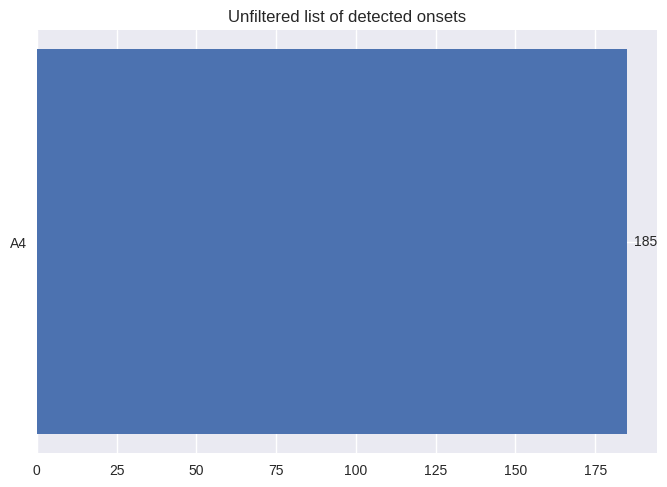

In [12]:
plt.title('Unfiltered list of detected onsets')
agg = Counter([o.note for e in episodes_valid for o in e.detected_audio_onsets])
bars= plt.barh(np.arange(len(agg.keys())), agg.values(), tick_label=list(agg.keys()));
plt.bar_label(bars, padding=5);
u.save_plot(f'onesets {bag_name}')

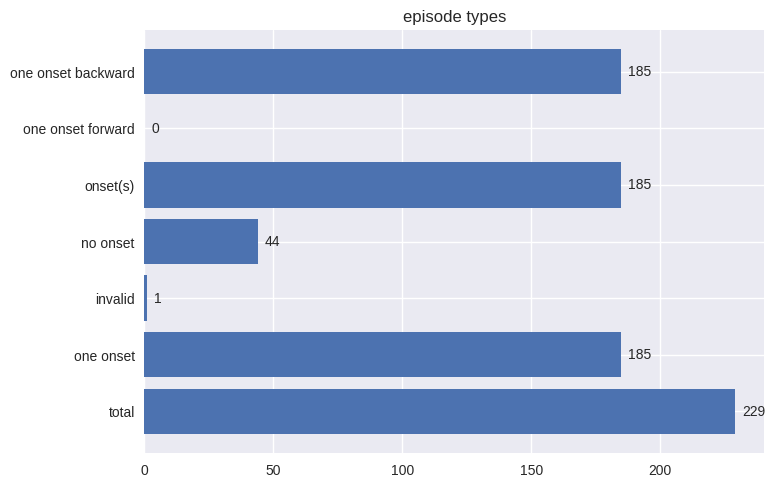

In [30]:
plt.title("episode types")
bars= plt.barh(
    np.arange(7),
    [len(episodes), len(episodes_with_one_onset), len(episodes_all)-len(episodes_valid), len(episodes_with_no_onset), len(episodes)-len(episodes_with_no_onset), len(episodes_with_one_onset_forward), len(episodes_with_one_onset_backward)],
    tick_label= ["total", "one onset", "invalid", "no onset", "onset(s)", "one onset forward", "one onset backward"]
    );
plt.bar_label(bars, padding=5);
u.save_plot(f'episodes {bag_name}')

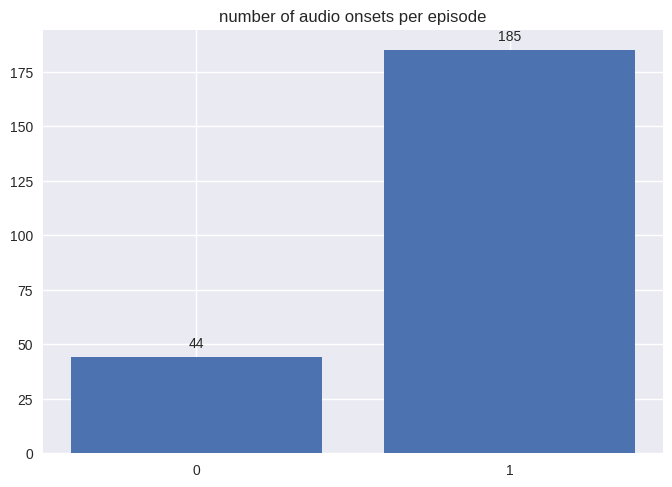

In [32]:
plt.title('number of audio onsets per episode')
onset_cnts = Counter([len(e.detected_audio_onsets) for e in episodes])
bars= plt.bar(*list(zip(*sorted(onset_cnts.items()))))
plt.xticks(list(onset_cnts.keys()))
plt.bar_label(bars, padding=5);
u.save_plot(f'onsets {bag_name}')

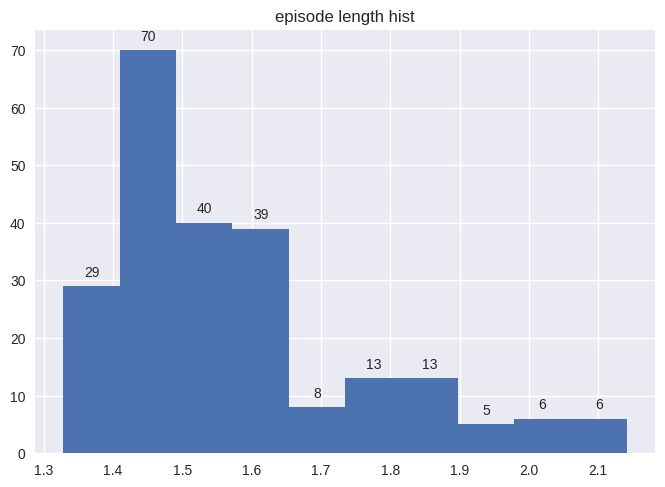

In [33]:
plt.title('episode length hist')
_,_,bars= plt.hist([e.header.stamp.to_sec() + e.length.to_sec() - e.start_execution.to_sec() for e in episodes]);
plt.bar_label(bars, padding=5);
u.save_plot(f'episode length {bag_name}')

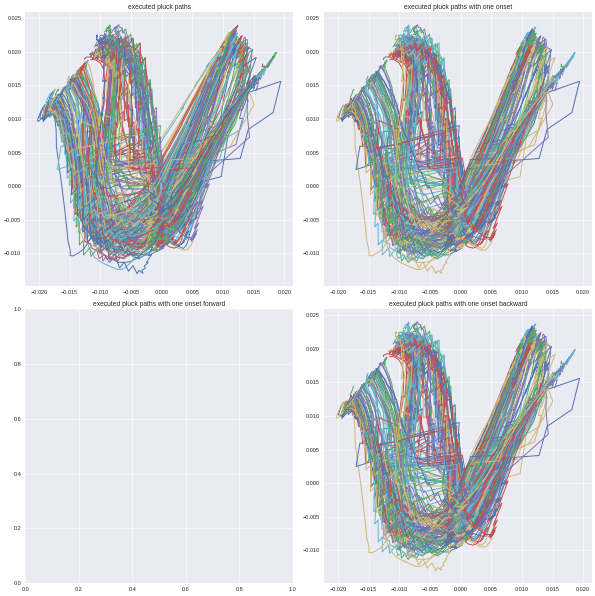

In [34]:
plt.figure(figsize=(15,15), dpi=40)
plt.subplot(2,2,1)
plt.title('executed pluck paths')
for e in episodes:
    plt.plot(*u.tip_path(e.executed_path))
plt.subplot(2,2,2)
plt.title('executed pluck paths with one onset')
for e in episodes_with_one_onset:
    plt.plot(*u.tip_path(e.executed_path))
plt.subplot(2,2,3)
plt.title('executed pluck paths with one onset forward')
for e in episodes_with_one_onset_forward:
    plt.plot(*u.tip_path(e.executed_path))
plt.subplot(2,2,4)
plt.title('executed pluck paths with one onset backward')
for e in episodes_with_one_onset_backward:
    plt.plot(*u.tip_path(e.executed_path))

plt.tight_layout()
u.save_plot(f'paths {bag_name}')

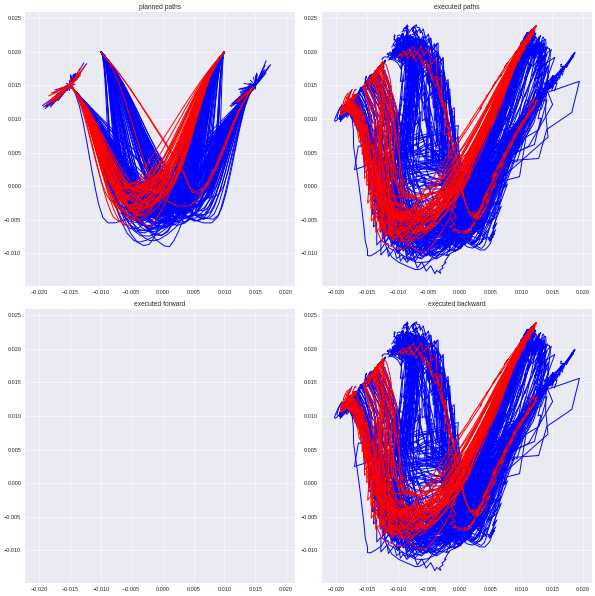

In [35]:
plt.figure(figsize=(15,15), dpi=40)

plt.subplot(2, 2, 1)
plt.title('planned paths')
for e in episodes_with_onset:
    plt.plot(*u.tip_path(e.planned_path), color='b')
for e in episodes_with_no_onset:
    plt.plot(*u.tip_path(e.planned_path), color='r')    

plt.subplot(2, 2, 2, sharey= plt.gca(), sharex= plt.gca())
plt.title('executed paths')
for e in episodes_with_onset:
    plt.plot(*u.tip_path(e.executed_path), color='b')
for e in episodes_with_no_onset:
    plt.plot(*u.tip_path(e.executed_path), color='r')

plt.subplot(2, 2, 3, sharey= plt.gca(), sharex= plt.gca())
plt.title('executed forward')
for e in episodes_with_one_onset_forward:
    plt.plot(*u.tip_path(e.executed_path), color='b')
for e in episodes_with_no_onset_forward:
    plt.plot(*u.tip_path(e.executed_path), color='r')

plt.subplot(2, 2, 4, sharey= plt.gca(), sharex= plt.gca())
plt.title('executed backward')
for e in episodes_with_one_onset_backward:
    plt.plot(*u.tip_path(e.executed_path), color='b')
for e in episodes_with_no_onset_backward:
    plt.plot(*u.tip_path(e.executed_path), color='r')

plt.tight_layout()
u.save_plot(f'episodes {bag_name}')

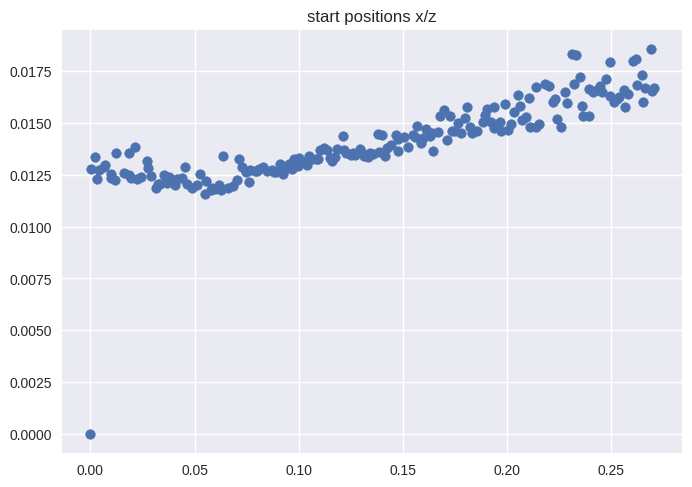

In [36]:
plt.title('start positions x/z')
plt.scatter(*list(zip(*[(e.finger_start_pose.pose.position.x, e.finger_start_pose.pose.position.z) for e in episodes_with_one_onset]+[(0.0,0.0)])))

u.save_plot(f'positions along string {bag_name}')

In [37]:
es= sorted(episodes_backward,key= lambda e: e.action_parameters.action_parameters[14])

fig, ax = plt.subplots()

LINES= 10
lines=[]
for x in range(LINES):
    lines.append( ax.plot([], c='b')[0] )

ax.set_xlim(-0.02, 0.02)
ax.set_ylim(-0.01, 0.025)
ax.set_aspect('equal', 'box')
ax.set_title('executed forward')

def animate(i):
    lines[i%LINES].set_data(u.tip_path(es[i].executed_path))
    lines[i%LINES].set_color('red' if len(es[i].detected_audio_onsets) == 0 else 'blue')
    ax.set_title(f"d = {es[i].action_parameters.action_parameters[14]:.3f}")
    return lines

anim = FuncAnimation(
    fig,
    animate,
    frames=len(es), interval=100)
video= anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()

u.save_anim(anim, f'plucks along string {bag_name}')

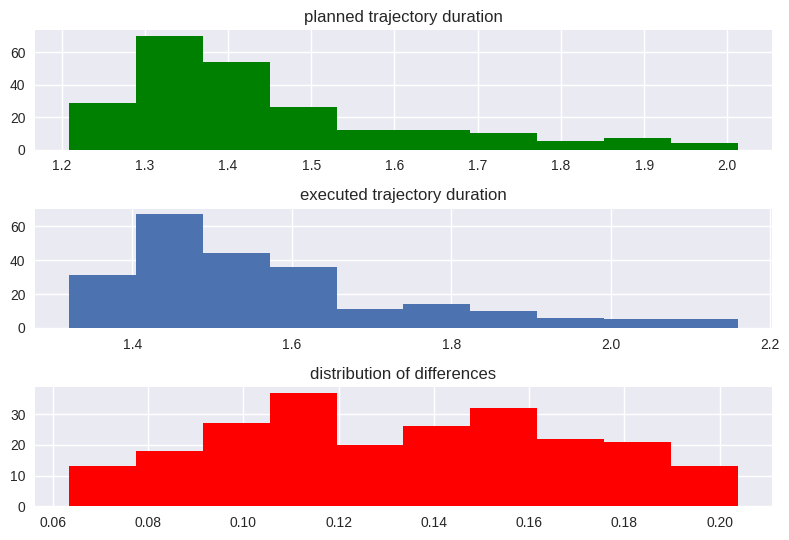

In [20]:
plt.subplot(3,1,1)
plt.title('planned trajectory duration')
plt.hist([(e.planned_trajectory.points[-1].time_from_start).to_sec() for e in episodes], color='g');
plt.subplot(3,1,2)
plt.title('executed trajectory duration')
plt.hist([(e.executed_trajectory.points[-1].time_from_start).to_sec() for e in episodes]);
plt.subplot(3,1,3)
plt.title('distribution of differences')
plt.hist([(e.executed_trajectory.points[-1].time_from_start - e.planned_trajectory.points[-1].time_from_start).to_sec() for e in episodes], color= 'red');
plt.tight_layout()
u.save_plot(f'actuation length {bag_name}')

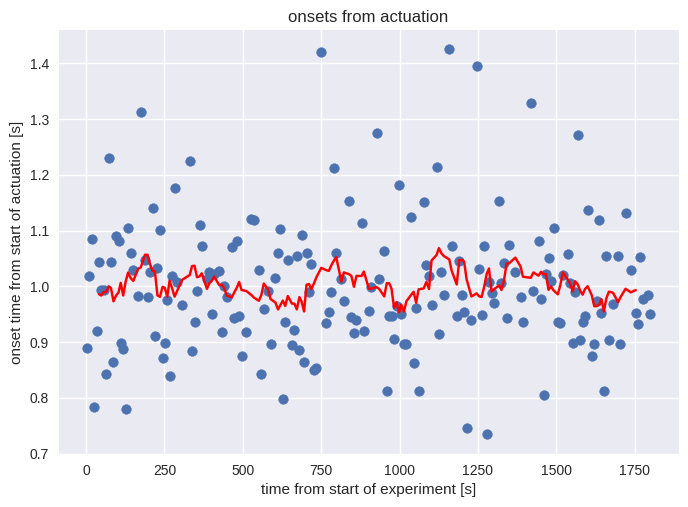

In [38]:
plt.title('onsets from actuation')
onsets = []

for e in episodes:
    for o in e.detected_audio_onsets:
        onsets.append((e.start_execution.to_sec()-start_time.to_sec(), (o.header.stamp - e.start_execution).to_sec()))

t,v = list(zip(*onsets))
plt.scatter(t,v);
averaging_window= 11
plt.plot(t[int(averaging_window/2):-int(averaging_window/2)], np.convolve(v, np.ones(averaging_window)/averaging_window, mode='valid'), 'r')

plt.xlabel('time from start of experiment [s]')
plt.ylabel('onset time from start of actuation [s]')

u.save_plot(f'onsets from actuation {bag_name}')

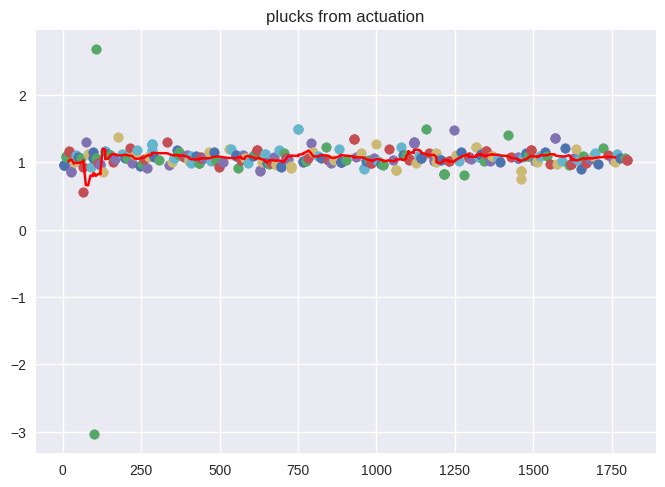

In [22]:
plt.title('plucks from actuation')
plucks_all = []
for i, e in enumerate(episodes):
    plucks = [((p.header.stamp-start_time).to_sec(), (p.header.stamp - e.start_execution).to_sec()) for p in e.detected_tactile_plucks]
    if len(plucks) > 0:
        plt.scatter(*list(zip(*plucks)))
    plucks_all+= plucks

t,v = list(zip(*plucks_all))
averaging_window= 11
plt.plot(t[int(averaging_window/2):-int(averaging_window/2)], np.convolve(v, np.ones(averaging_window)/averaging_window, mode='valid'), 'r')

u.save_plot(f'plucks from actuation {bag_name}')

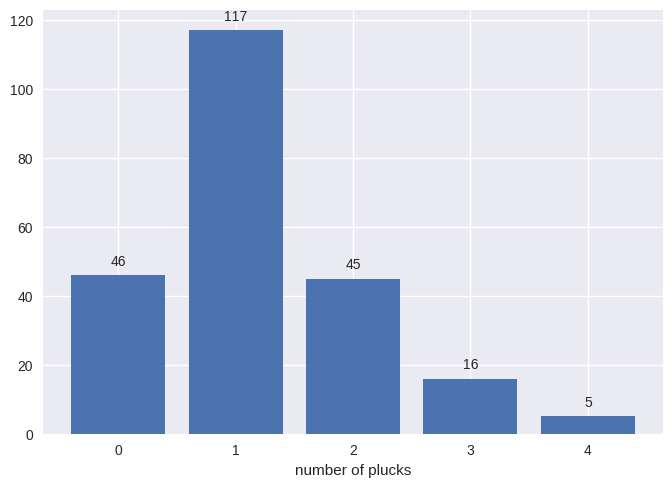

In [23]:
plucks_cnt = Counter(len(e.detected_tactile_plucks) for e in episodes)
bars= plt.bar(*list(zip(*plucks_cnt.items())));
plt.gca().set_xticks(range(len(plucks_cnt)))
plt.xlabel('number of plucks')

plt.bar_label(bars, padding=5);

u.save_plot(f'plucks {bag_name}')

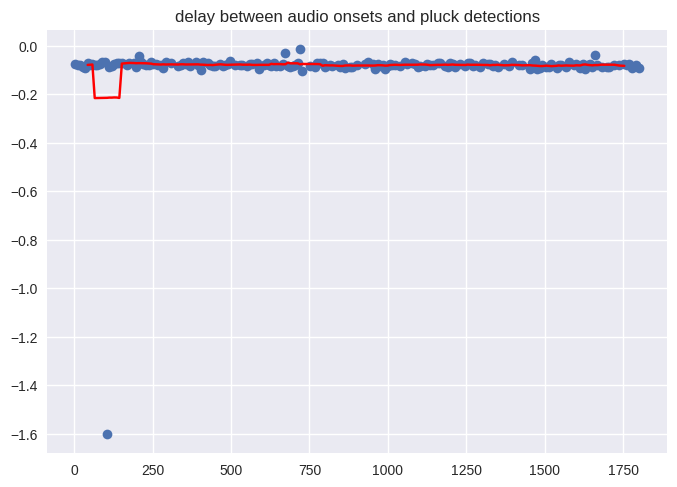

In [42]:
audio_tactile_delay_time= np.array([(e.detected_audio_onsets[-1].header.stamp - episodes_with_one_onset[0].header.stamp).to_sec() for e in episodes_with_one_onset if len(e.detected_tactile_plucks) > 0])
audio_tactile_delay=np.array([(e.detected_audio_onsets[-1].header.stamp - e.detected_tactile_plucks[-1].header.stamp).to_sec() for e in episodes_with_one_onset if len(e.detected_tactile_plucks) > 0])
audio_tactile_delay_idx=[i for i,e in enumerate(episodes_with_one_onset) if len(e.detected_tactile_plucks) > 0]

# plt.plot(audio_tactile_delay_time[audio_tactile_delay > -0.4], audio_tactile_delay[audio_tactile_delay > -0.4], 'o')
plt.plot(audio_tactile_delay_time, audio_tactile_delay, 'o')
averaging_window= 11
plt.plot(audio_tactile_delay_time[int(averaging_window/2):-int(averaging_window/2)], np.convolve(audio_tactile_delay, np.ones(averaging_window)/averaging_window, mode='valid'), 'r')
plt.title("delay between audio onsets and pluck detections");

u.save_plot(f'onsets plucks delay {bag_name}')

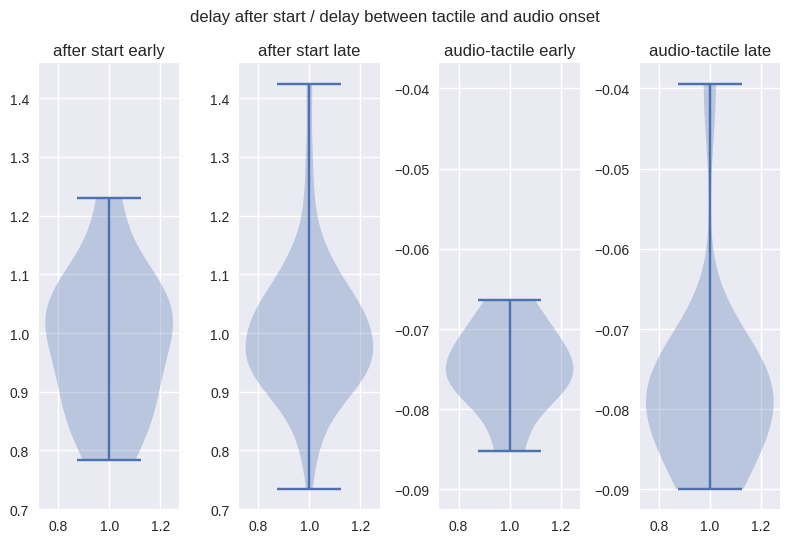

In [25]:
t_early = 100
t_late = len(episodes_with_onset)-100
i_early = len(episodes_with_onset) / 10
i_late = len(episodes_with_onset) - i_early

onsets_early = [o for t, o in onsets if t < t_early]
onsets_late = [o for t, o in onsets if t > t_late]
plt.suptitle('delay after start / delay between tactile and audio onset')
plt.subplot(1,4,1)
ax = plt.gca()
plt.title('after start early')
if len(onsets_early) > 0:
    plt.violinplot(onsets_early);
plt.subplot(1,4,2, sharey= ax)
plt.title('after start late')
plt.violinplot(onsets_late);

plt.subplot(1,4,3)
ax = plt.gca()
plt.title('audio-tactile early')
plt.violinplot([(e.detected_audio_onsets[-1].header.stamp-e.detected_tactile_plucks[-1].header.stamp).to_sec() for i, e in enumerate(episodes_with_onset) if len(e.detected_tactile_plucks) ==1 and i < i_early]);
plt.subplot(1,4,4, sharey= ax)
plt.title('audio-tactile late')
plt.violinplot([(e.detected_audio_onsets[-1].header.stamp-e.detected_tactile_plucks[-1].header.stamp).to_sec() for i, e in enumerate(episodes_with_onset) if len(e.detected_tactile_plucks) ==1 and i > i_late]);
plt.tight_layout()
u.save_plot(f'delays early-late {bag_name}')

In [26]:
%%html
<!-- allegedly works in jupyer lab -->
<style>
    .jp-OutputArea-child {
        display: inline-block;
    }
</style>

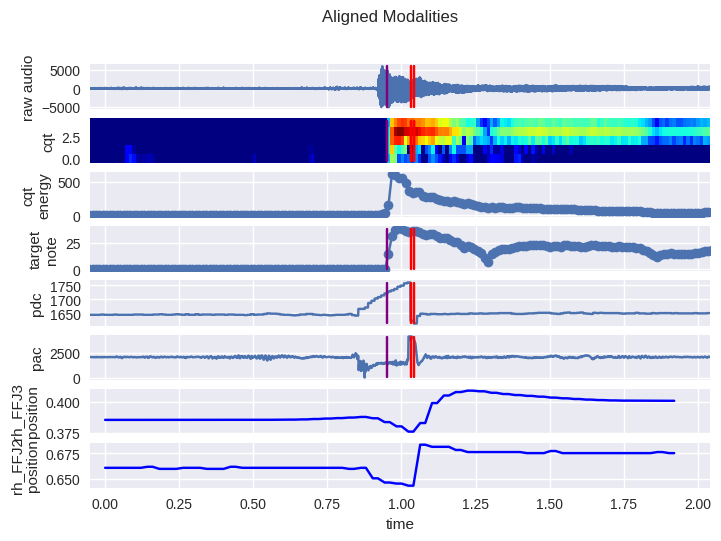

In [27]:
e = episodes_with_one_onset[-1]
u.plot_aligned_audio_tactile(e, context=1.0)

NameError: name 'librosa' is not defined

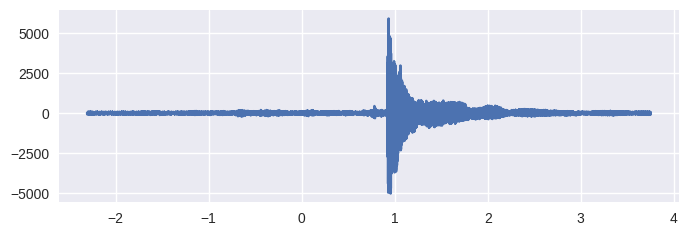

In [28]:
audio = u.audio_from_episode(e)
data_start = (e.audio_data.header.stamp-e.start_execution).to_sec()
ax= plt.subplot(2,1,1)
plt.plot(data_start + np.arange(audio.size)/e.audio_info.sample_rate, audio)

cqt = np.abs(
    librosa.cqt(
        y=audio,
        sr=e.audio_info.sample_rate,
        hop_length=e.cqt.hop_length,
        fmin=librosa.note_to_hz('C2'),
        n_bins=74,
    )
)[25:40]
data_start = (e.audio_data.header.stamp-e.start_execution).to_sec()
X= np.tile((data_start + np.arange(cqt.shape[1])*e.cqt.hop_length/e.cqt.sample_rate)[:, np.newaxis], cqt.shape[0]).T
Y= np.tile(np.arange(cqt.shape[0])[:,np.newaxis], cqt.shape[1])
plt.subplot(2,1,2, sharex= ax)
plt.pcolormesh(X, Y, cqt, cmap='jet')
plt.xlim([0.9, 1.2])


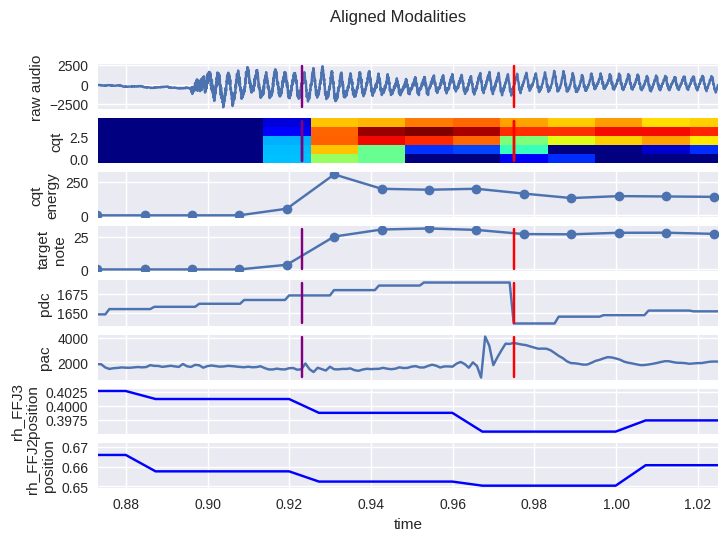

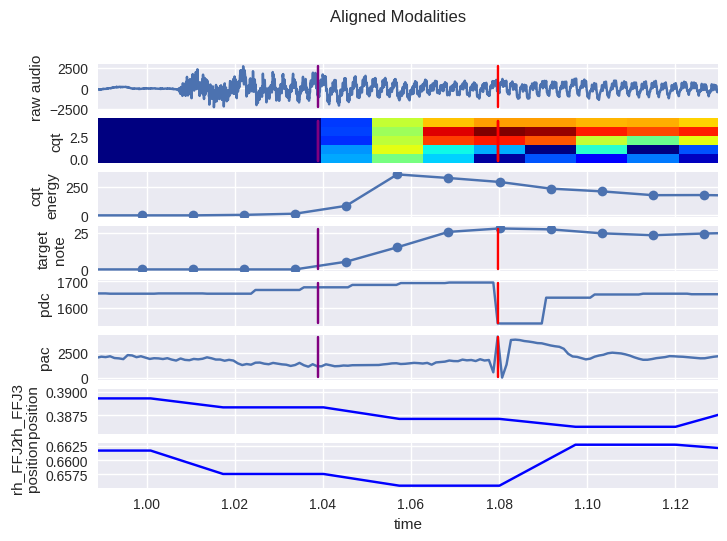

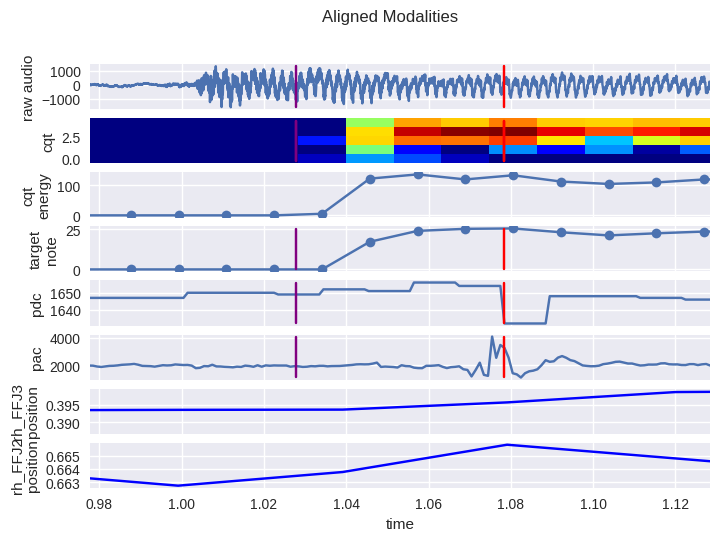

In [49]:
e = episodes_with_one_onset[0]
u.plot_aligned_audio_tactile(e, context=0.05)
plt.figure()
e = episodes_with_one_onset[len(episodes_with_one_onset)//2+1]
u.plot_aligned_audio_tactile(e, context=0.05)
plt.figure()
e = episodes_with_one_onset[-1]
u.plot_aligned_audio_tactile(e, context=0.05)

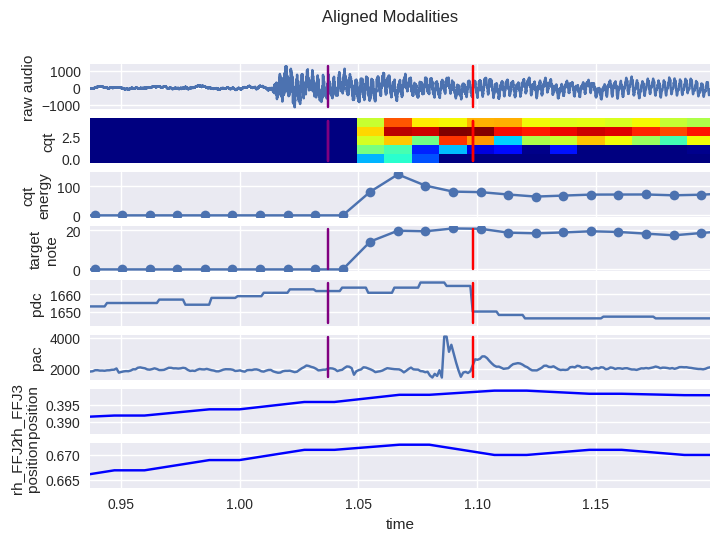

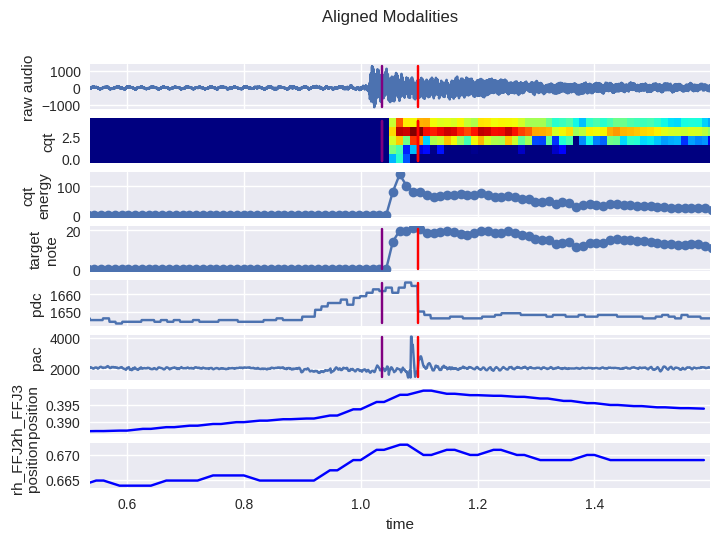

In [26]:
e = episodes_with_one_onset[13]
u.plot_aligned_audio_tactile(e, context=0.1)
plt.figure()
u.plot_aligned_audio_tactile(e, context=0.5)

In [27]:
cqt= u.cqt_from_episode(e)
idx= np.argmax(cqt[:,33])
peak= e.cqt.header.stamp.to_sec() + (idx * e.cqt.hop_length / e.cqt.sample_rate)
peak- e.start_execution.to_sec()

1.0898332595825195

In [28]:
e.detected_tactile_plucks

[header: 
   seq: 456
   stamp: 
     secs: 1685626809
     nsecs: 109712689
   frame_id: ''
 finger: "ff"
 strength: 15.0]

In [29]:
N=184
ei, e = N, episodes_with_one_onset[N]

if N < 0:
    ei, e = random.choice([(i,e) for i,e in enumerate(episodes_with_one_onset)])

header= f'Episode {ei}'
print(f'{header}\n{"-"*len(header)}\n\n'
      f'start: {e.header.stamp.to_sec()}\n'
      f'length: {e.length.to_sec()}\n')

e_avg_sample_dt= ((e.executed_trajectory.points[-1].time_from_start - e.executed_trajectory.points[0].time_from_start)/len(e.executed_trajectory.points)).to_sec()
print(f'executed trajectory sampled at {1/e_avg_sample_dt}\n')    

print(f'onsets: {len(e.detected_audio_onsets)}')
for o in e.detected_audio_onsets:
    print(f'       - {o.note} at {(o.header.stamp-e.start_execution).to_sec():.6}')
print(f'plucks: {len(e.detected_tactile_plucks)}')
for p in e.detected_tactile_plucks:
    print(f'       - {(p.header.stamp-e.start_execution).to_sec():.6}')
    
u.plot_episode(e);

IndexError: list index out of range

In [ ]:
episodes_with_many_onsets = [e for e in episodes if len(e.detected_audio_onsets) >= 4]

if (nr:= len(episodes_with_many_onsets)) > 0:
    print(f"{nr} episodes with many onsets")
    u.plot_episode(random.choice(episodes_with_many_onsets), joints= False)

In [ ]:
onsets= []
for i, e in enumerate(episodes_with_two_onsets):
    for o in e.detected_audio_onsets:
        onsets.append((i, (o.header.stamp - e.start_execution).to_sec()))
if len(onsets) > 0:
    plt.title('2 onset episodes onset after execution')
    plt.scatter(*list(zip(*onsets)))
for i, o in onsets:
    plt.text(i+0.05, o, str(i), fontsize=12)

In [ ]:
u.play_audio(e)

In [ ]:
e.detected_audio_onsets

[header: 
   seq: 243
   stamp: 
     secs: 1685626760
     nsecs: 852618919
   frame_id: ''
 note: "A4"
 confidence: 0.9154443144798279
 loudness: 11.722394943237305
 duration: 
   secs: 0
   nsecs:         0]

In [ ]:
[idx for idx, e in enumerate(episodes) if len(e.detected_tactile_plucks) > 8]

[]

In [ ]:
multiple_tactile_plucks= [(i,e) for i,e in enumerate(episodes_with_one_onset) if len(e.detected_tactile_plucks) >= 2]
print(f"{len(multiple_tactile_plucks)} episodes with multiple detected plucks: {[i for i,_ in multiple_tactile_plucks]}")

5 episodes with multiple detected plucks: [2, 3, 11, 12, 17]


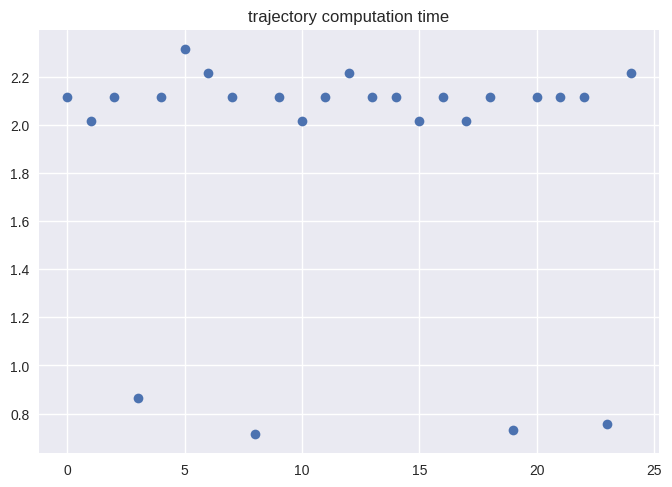

In [ ]:
# plt.figure(figsize=(12,8))
plt.title('trajectory computation time')
plt.plot([(e.start_execution-e.header.stamp).to_sec() for e in episodes], 'o');

u.save_plot(f'processing time {bag_name}')

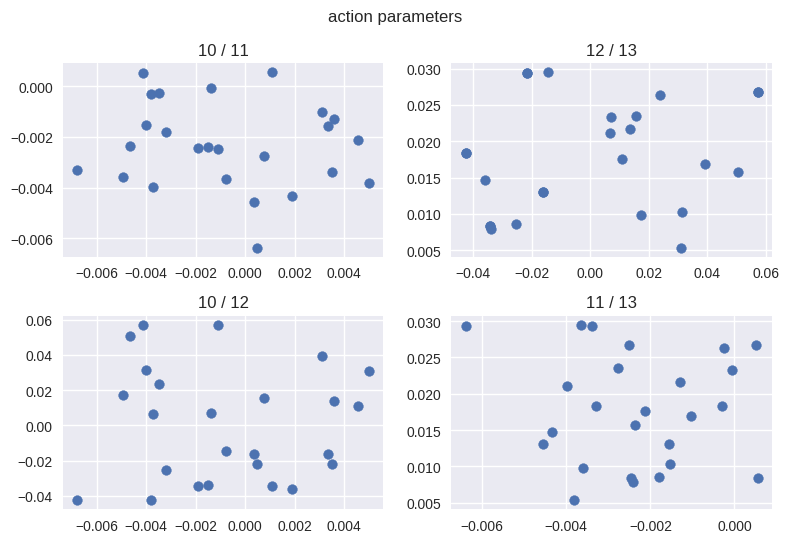

In [ ]:
plt.suptitle('action parameters')
pairs = [(10,11), (12,13), (10,12), (11,13)]

for i, (a,b) in enumerate(pairs):
    plt.subplot(2,2,i+1)
    plt.title(f'{a} / {b}')
    plt.scatter([e.action_parameters.action_parameters[a] for e in episodes], [e.action_parameters.action_parameters[b] for e in episodes])
plt.tight_layout()

u.save_plot(f'parameter coverage {bag_name}')

In [ ]:
cqt = u.cqt_from_episode(e)
print('        index:', ei)
print('    cqt start:', e.cqt.header.stamp.to_sec())
print('episode start:', e.header.stamp.to_sec())
print('        onset:', e.detected_audio_onsets[0].header.stamp.to_sec())
print('  episode end:', (e.header.stamp+e.length).to_sec())
print('      cqt end:', (e.cqt.header.stamp.to_sec() + e.cqt.hop_length*cqt.shape[0]/e.cqt.sample_rate))

print('   hop length:', e.cqt.hop_length/e.cqt.sample_rate)

onset_cqt_idx = int((e.detected_audio_onsets[-1].header.stamp-e.cqt.header.stamp).to_sec()/512 * 44100)
print('onset index: ', onset_cqt_idx)

        index: 9
    cqt start: 1685626756.2730021
episode start: 1685626757.203725
        onset: 1685626760.852619
  episode end: 1685626761.4936974
      cqt end: 1685626762.3334103
   hop length: 0.011609977324263039
onset index:  394


(1.0, 2.0)

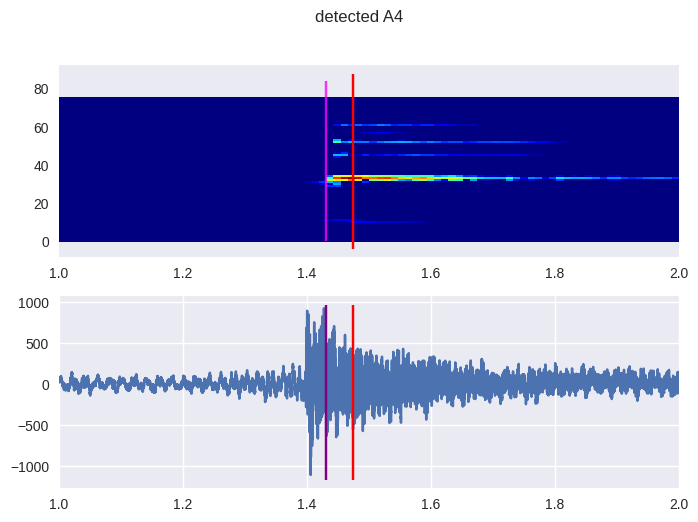

In [ ]:
plt.subplot(2,1,1)
plt.suptitle(f"detected {e.detected_audio_onsets[-1].note}");
u.plot_audio(e)
plt.subplot(2,1,2, sharex= plt.gca())
u.plot_raw_audio(e)
plt.xlim([1, 2])

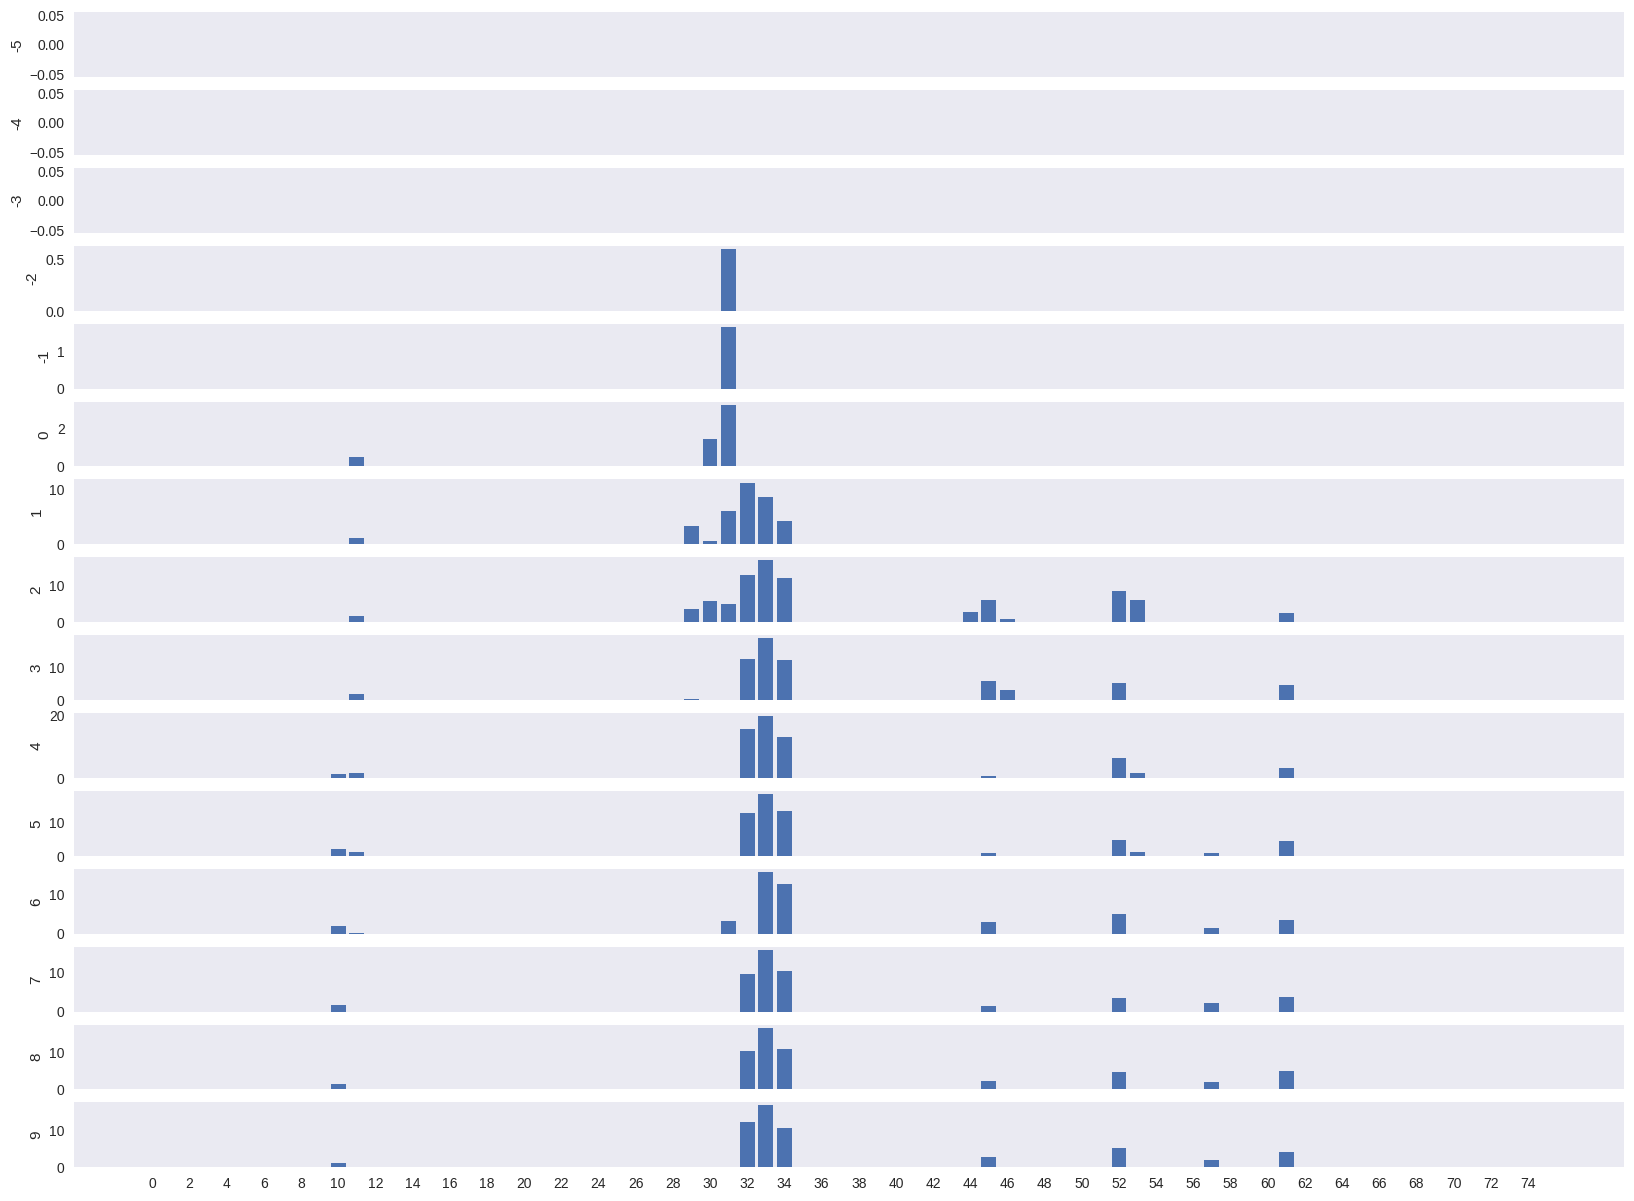

In [ ]:
plt.figure(figsize=(20,15),dpi= 100)
for i in range(-5, 10):
    plt.subplot(15,1, i+6)
    plt.ylabel(f'{i}')
    plt.bar(np.arange(0, cqt.shape[1]), cqt[onset_cqt_idx+i,:])
    plt.xticks(np.arange(0, cqt.shape[1], 2))
    plt.grid(False)
    u.label_outer()

u.save_plot(f"onset dynamics for last onset in random episode {ei} {bag_name}")

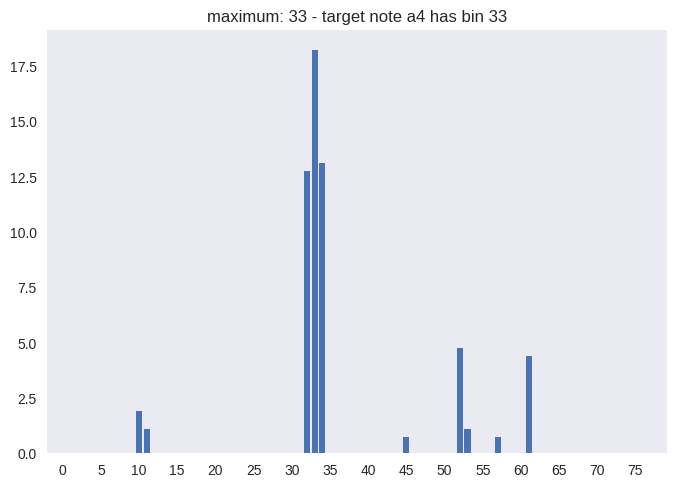

In [ ]:
delta= 5
maximum= np.argmax(cqt[onset_cqt_idx+delta,2:])+2
plt.title(f"maximum: {maximum} - target note {note} has bin {note_bucket}")
plt.bar(range(2, e.cqt.number_of_semitones), cqt[onset_cqt_idx+delta,2:])
plt.xticks(np.arange(0, cqt.shape[1], 5))
plt.grid(False)

In [ ]:
onset_cqt_idxs = [int((e.detected_audio_onsets[0].header.stamp-e.cqt.header.stamp).to_sec()/512*e.audio_info.sample_rate) for e in episodes_with_one_onset]

In [ ]:
cqts= [u.cqt_from_episode(e) for e in episodes_with_one_onset]

In [ ]:
onset_cqts= np.array([c[i,:] for c, i in zip(cqts, onset_cqt_idxs)])

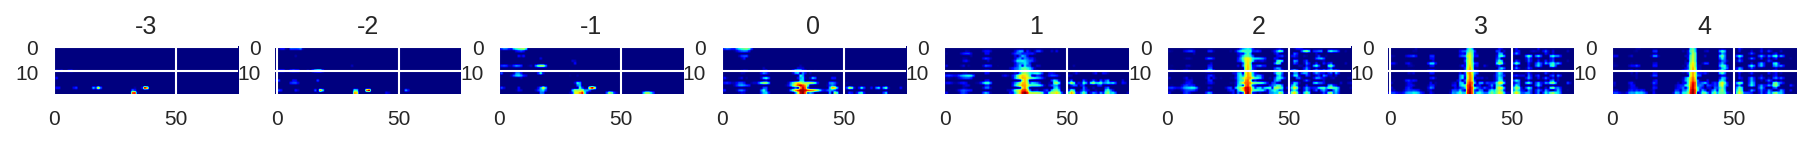

In [ ]:
plt.figure(figsize=(15,8),dpi= 150)
shared_ax= None
offsets = list(range(-3, 5))
for idx,i in enumerate(offsets):
    onset_cqts= np.array([c[oi+i,:] for c, oi in zip(cqts, onset_cqt_idxs)])
    shared_ax = plt.subplot(1,len(offsets), idx+1, sharey= shared_ax)
    plt.title(f'{i}')
    plt.imshow(onset_cqts[onset_cqts[:,note_bucket].argsort()], cmap='jet')

u.save_plot(f"onset dynamics across episodes {bag_name}")

/tmp/ipykernel_16577/2179699219.py:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax= plt.subplot(1,20, subplotidx, sharey= ax)


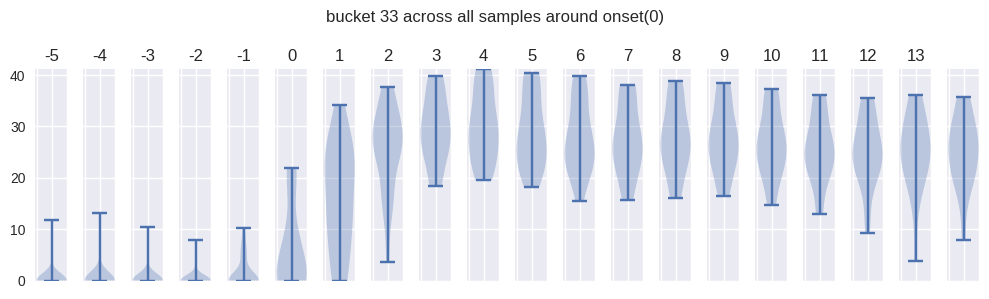

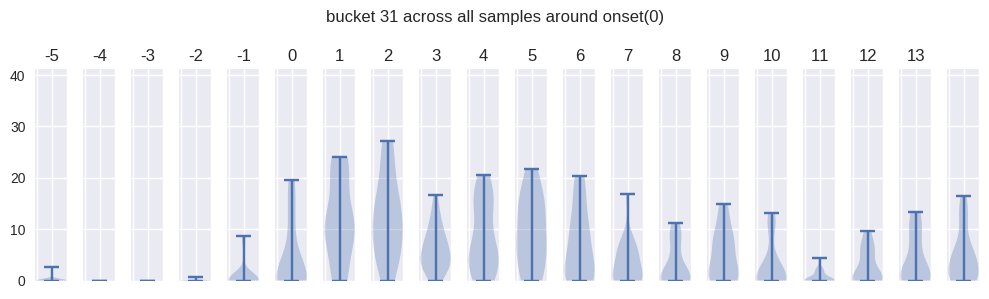

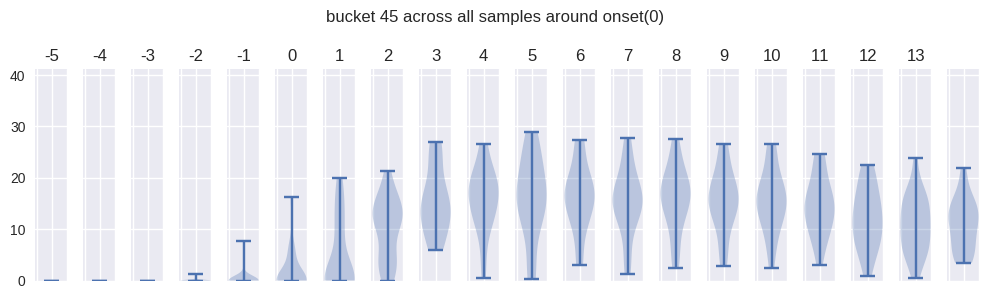

In [ ]:
# E5 - 40

compare_buckets= [note_bucket, note_bucket-2, note_bucket+12]
maximum_power= max([c[oi-5:oi+14, compare_buckets].max() for c, oi in zip(cqts, onset_cqt_idxs)])
#print(maximum_power)
#maximum_power=20000

for bucket in compare_buckets:
    plt.figure(figsize=(10,3),dpi= 100)
    plt.tick_params('y', labelleft=True)
    ax= None
    plt.suptitle(f'bucket {bucket} across all samples around onset(0)')
    subplotidx= 1
    first= True
    for i in range(-5,15):
        onset_cqts= np.array([c[oi+i,:] for c, oi in zip(cqts, onset_cqt_idxs)])
        ax= plt.subplot(1,20, subplotidx, sharey= ax)
        if not first:
            ax.tick_params(labelleft=False)
        first= False
        ax.set_ylim(0, maximum_power)
        subplotidx+= 1
        if subplotidx <= 20:
            plt.title(f'{i}')
        plt.tick_params('x', labelbottom=False)
        plt.violinplot(onset_cqts[:,bucket])
        #plt.hist(onset_cqts[:,bucket], orientation= 'horizontal')
    plt.tight_layout()

In [ ]:
note_after_transient = np.array([c[oi+delta,[note_bucket, note_bucket+12, note_bucket-5, note_bucket+12+7]].sum() for c, oi in zip(cqts, onset_cqt_idxs)])

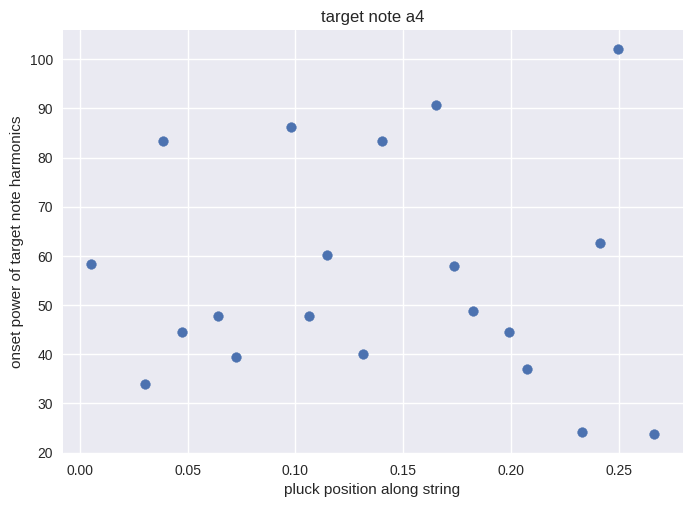

In [ ]:
#big_plot()
plt.scatter([e.action_parameters.action_parameters[-1] for e in episodes_with_one_onset], note_after_transient)
plt.title(f'target note {note}');
plt.xlabel('pluck position along string');
plt.ylabel('onset power of target note harmonics');

u.save_plot(f'dynamics for string positions {bag_name}')

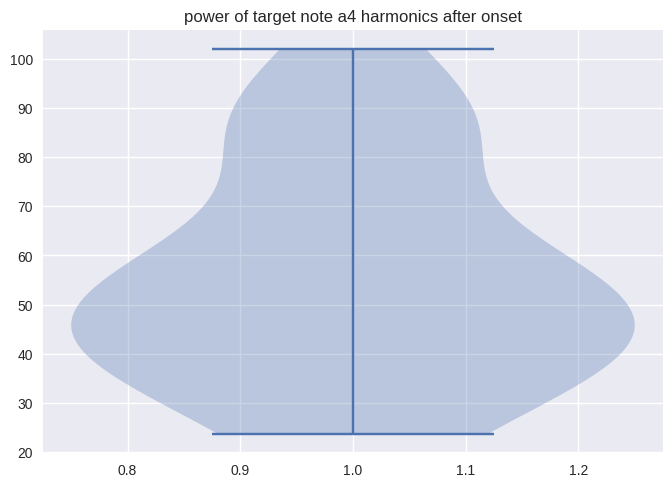

In [ ]:
plt.title(f'power of target note {note} harmonics after onset')
plt.violinplot(note_after_transient);

u.save_plot(f'distribution of onset power {bag_name}')

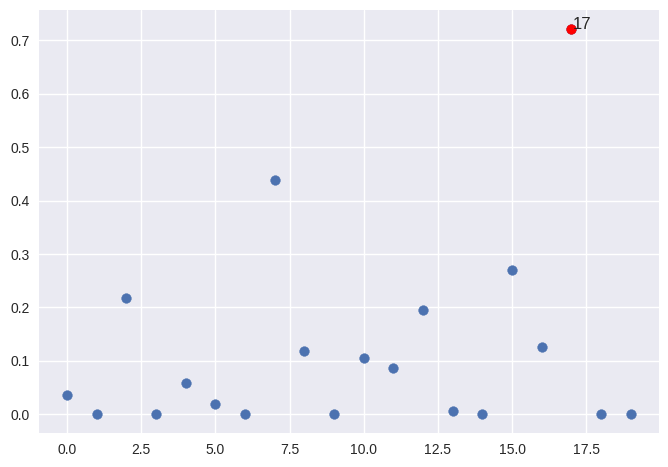

In [ ]:
diff_note_and_neighbor = np.array([c[oi+delta,[note_bucket-4, note_bucket+4]].sum()/c[oi+delta,[note_bucket]].sum() for c, oi in zip(cqts, onset_cqt_idxs)])
# u.big_plot()
plt.scatter(*list(zip(*list(enumerate(diff_note_and_neighbor)))))
outliers= [(i,e) for (i,e) in enumerate(diff_note_and_neighbor) if e > diff_note_and_neighbor.mean() + 2.5*diff_note_and_neighbor.std()]
plt.scatter(*list(zip(*outliers)), c='r')

for i, o in outliers:
    plt.text(i+0.05, o, str(i), fontsize=12)

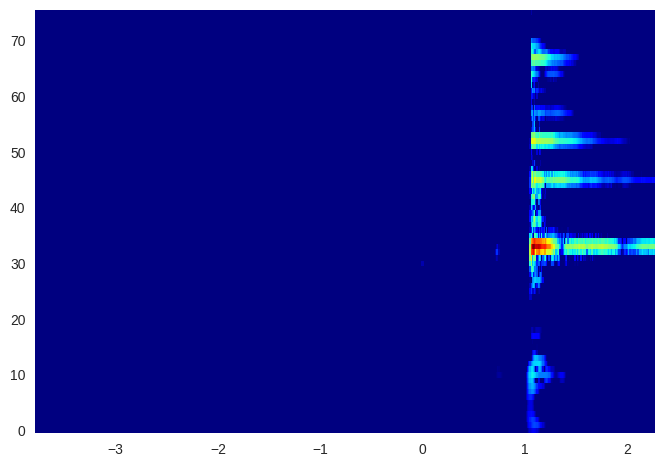

In [ ]:
e= episodes_with_one_onset[17]
#cqt= cqts[17]
u.plot_cqt(e)

# X= np.tile(np.arange(cqt.shape[0])[:,np.newaxis], cqt.shape[1])
# Y= np.tile((np.arange(cqt.shape[1])*e.cqt.hop_length/e.cqt.sample_rate + (e.cqt.header.stamp - e.start_execution).to_sec())[:, np.newaxis], cqt.shape[0]).T
# plt.pcolormesh(Y, X, cqt, cmap='jet')


In [ ]:
N=140
u.plot_audio(episodes_with_one_onset[N])
u.play_audio(episodes_with_one_onset[N])

In [ ]:
idx = 0
N= 10

samples= list(reversed(sorted(enumerate(note_after_transient), key=lambda v: v[1])))[::int(len(episodes_with_one_onset)/N+1)]
print(f"{len(samples)} samples")

In [ ]:
plt.figure(figsize=(10,20), dpi=150)
lim= None
for i, s in enumerate(samples):
    plt.subplot(len(samples), 1, i+1)
    u.plot_raw_audio(episodes_with_one_onset[s[0]])
    if lim is None:
        lim = plt.gca().get_ylim()
    else:
        plt.ylim(lim)

In [ ]:
# Play samples

if False:
    idx=0
    for idx, (i, v) in enumerate(samples):
        e= episodes_with_one_onset[i]
        length = len(e.audio_data.audio.data)/2 / e.audio_info.sample_rate
        play_audio(e)
        print(f"{i} ({idx} / {len(samples)}); length: {length:2}; volume: {v}")
        rospy.sleep(rospy.Duration(length))

In [ ]:
u.big_plot()
note_after_transient_normalized= note_after_transient/np.max(note_after_transient)
plt.plot(note_after_transient, 'o')
plt.plot(sorted(note_after_transient), 'o');

plt.plot([i for i,o in outliers], note_after_transient[[i for i,_ in outliers]], 'o', color='red')

u.save_plot(f"volume distribution {bag_name}")

In [ ]:
for i in (note_after_transient > 80000).nonzero()[0]:
    plt.figure()
    plt.title(f"{i}")
    plot_audio(episodes_with_one_onset[i])
    
# for i in (note_after_transient > 50000).nonzero()[0]:
#     play_audio(episodes_with_one_onset[i])


In [ ]:
plt.figure(figsize=(15,15), dpi=150)

for i, e in enumerate([e for e in episodes_with_no_onset if e.action_parameters.action_parameters[12]>0]):
    plt.plot([-p.pose.position.y for p in e.executed_path.poses], [p.pose.position.z for p in e.executed_path.poses], color='lightblue')

for i, e in enumerate([e for e in episodes_with_one_onset if e.action_parameters.action_parameters[12]>0]):
    plt.plot([-p.pose.position.y for p in e.executed_path.poses], [p.pose.position.z for p in e.executed_path.poses], color= plt.get_cmap('RdPu')(note_after_transient_normalized[i]))
#plt.gca().set_aspect('equal', 'box')
plt.gca().axis('equal')
plt.title('plucks by power')
#plt.colorbar(mpl.cm.ScalarMappable(norm=None, cmap=plt.get_cmap('gist_rainbow')))
u.save_plot(f'plucks by power {note} {bag_name}')

In [ ]:
plt.figure(figsize=(15,15), dpi=100)
for i,e in enumerate([e for e in episodes_with_one_onset if e.action_parameters.action_parameters[12] < 0]):
    plt.plot([-p.pose.position.y for p in e.commanded_path.poses], [p.pose.position.z for p in e.commanded_path.poses], color= plt.get_cmap('RdPu')(note_after_transient_normalized[i]))

#plt.suptitle('plucks by power')
u.save_plot(f'cmd plucks by power {note} {bag_name}')
#loud_episodes = [e for i, e in enumerate(episodes_with_one_onset) if note_after_transient[i] > 10000]
#for e in loud_episodes:
#    plt.plot([p.pose.position.y for p in e.commanded_path.poses], [p.pose.position.z for p in e.commanded_path.poses], 'r')

In [ ]:
parameters = np.hstack([np.array([e.action_parameters.action_parameters for e in episodes_with_one_onset]), note_after_transient[:, np.newaxis]])
parameters_no_onset = np.array([e.action_parameters.action_parameters for e in episodes_with_no_onset])

In [ ]:
N=4
string_segment_length = string_length / N
string_segments= np.arange(0, string_length, string_length/N)+ string_segment_length/2

In [ ]:
ax= None

margin= string_segment_length/2

def check_params_right(p):
    return (np.abs(p[:, 14] - d) < margin) & (p[:,12] < 0)
def check_params_left(p):
    return (np.abs(p[:, 14] - d) < margin) & (p[:,12] > 0)

normalize = mpl.colors.Normalize(vmin= 0.0, vmax= max(parameters[:,15]))

directions=["forward", "back"]
for direction, check_params in zip(directions, [check_params_right, check_params_left]):
    u.big_plot()
    for i, d in enumerate(string_segments):
        ax= plt.subplot(1,4, i+1, sharex= ax, sharey= ax);
        ax.set_box_aspect(1)

        p = parameters_no_onset[check_params(parameters_no_onset)]
        plt.quiver(-p[:, 10], p[:, 11], -p[:, 12], p[:, 13], scale=.4, angles='xy', color='lightblue');

        p = parameters[check_params(parameters)]
        plt.title(f'd = {d:.3f}');
        q= plt.quiver(-p[:, 10], p[:, 11], -p[:, 12], p[:, 13], p[:, 15], scale=.4, angles='xy', cmap=plt.get_cmap('RdPu'), norm= normalize);

    plt.subplots_adjust(bottom=0.12)
    cbar_ax = plt.gcf().add_axes([0.125, 0.25, 0.775, 0.05])
    plt.colorbar(q, cax=cbar_ax, orientation='horizontal');
    u.save_plot(f'volume for waypoints along string {note} {direction} {bag_name}')

In [ ]:
from itertools import combinations

plt.suptitle('pairwise volume plots of action parameters');
plt.figure(figsize=(15,8), dpi=50)
sidx= 1
for i,j in combinations([10,11,12,13], 2):
    plt.subplot(2,3,sidx)
    plt.title(f'{i}/{j}')
    sidx+= 1
    plt.scatter([e.action_parameters.action_parameters[i] for e in episodes_with_one_onset], [e.action_parameters.action_parameters[j] for e in episodes_with_one_onset], cmap=plt.get_cmap('gist_rainbow'), c=note_after_transient_normalized)
    #plt.scatter([e.action_parameters.action_parameters[i] for e in episodes_with_no_onset], [e.action_parameters.action_parameters[j] for e in episodes_with_no_onset], color='r')

In [ ]:
max_pdc_peak = [np.max([t.tactile.pdc for t in e.tactile_data])-e.tactile_data[0].tactile.pdc for e in episodes_with_one_onset]

plt.figure(figsize=(10,8), dpi=75)
plt.scatter(
    max_pdc_peak,
    note_after_transient,
    # would need to be normalized
    #c= plt.get_cmap('jet')([e.action_parameters.action_parameters[0] for e in episodes_with_one_onset])
    )

#plt.plot(np.arange(0,400), model.predict(np.arange(0,400).reshape(-1,1)))
plt.xlabel('peak in tactile pressure')
plt.ylabel('amplitude of target note')
#plt.xlim(0, 800)
u.save_plot(f'amplitude vs tactile {note} {bag_name}')

In [ ]:
#from sklearn.linear_model import RANSACRegressor
#
#model = RANSACRegressor(residual_threshold=100, max_trials=1000).fit(np.array(max_pdc_peak).reshape(-1,1),np.array(note_after_transient))


In [ ]:
######
######
# Neural Network Playground
######
######

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
parameter_tensor = F.normalize(torch.FloatTensor([e.action_parameters.action_parameters for e in episodes_with_one_onset]), dim=1)
volume_tensor = F.normalize(torch.FloatTensor([[n] for n in note_after_transient]), dim=0)

In [ ]:
ds= [(parameter_tensor[i,:], volume_tensor[i]) for i in range(len(note_after_transient))]

In [ ]:
dl = torch.utils.data.DataLoader(ds, shuffle= True)

In [ ]:
# regress volume
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(15, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        #x = F.softmax(self.fc1(x))
        #x = F.relu(self.fc2(x))
        return x

net = Net()
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(1,500):
    for i, data in enumerate(dl):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    if epoch % 50 == 0:
        print(f'{epoch}')

In [ ]:
pred = net(torch.FloatTensor([e.action_parameters.action_parameters for e in episodes_with_one_onset])).detach().numpy();
pred.shape

plt.figure(figsize=(10,20), dpi=100)
plt.title('action parameters')
sidx= 1
combs = list(combinations([10,11,12,13], 2))
for i,j in combs:
    plt.subplot(len(combs),2,sidx)
    sidx+=1
    plt.title(f'{i}/{j} ground truth')
    plt.scatter([e.action_parameters.action_parameters[i] for e in episodes_with_one_onset], [e.action_parameters.action_parameters[j] for e in episodes_with_one_onset], cmap=plt.get_cmap('gist_rainbow'), c=note_after_transient_normalized)
    plt.subplot(len(combs),2,sidx)
    plt.title(f'{i}/{j} predicted')
    sidx+= 1
    plt.scatter([e.action_parameters.action_parameters[i] for e in episodes_with_one_onset], [e.action_parameters.action_parameters[j] for e in episodes_with_one_onset], cmap=plt.get_cmap('gist_rainbow'), c=pred)

In [ ]:
e= episodes_with_one_onset[1]
#plt.figure(dpi=100)
N=5
ax = plt.subplot(N,1,1)
plot_raw_audio(e)
ax = plt.subplot(N,1,2, sharex=ax)
plot_audio(e)
ax = plt.subplot(N,1,3, sharex=ax)
plot_tactile(e)
ax = plt.subplot(N,1,4, sharex=ax)
plot_tactile_ac(e)
ax = plt.subplot(N,1,5, sharex=ax)
#plot_joint(e, "rh_FFJ2")
#plot_joint(e, "rh_FFJ3")
for ax in plt.gcf().axes:
    try:
        ax.label_outer()
    except:
        pass
plt.tight_layout()

In [ ]:
signal = np.array(struct.unpack('{0}h'.format(int(len(e.audio_data.audio.data)/2)), e.audio_data.audio.data), dtype=float)
plt.plot(np.arange(len(signal), dtype=float)/e.audio_info.sample_rate+e.audio_data.header.stamp.to_sec() - e.start_execution.to_sec(), signal)